# Predicting Bitcoin Closing Price Using Amazon SageMaker - DeepAR

Let's start by importing necessary libraries for this notebook.

In [138]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import os
import boto3
import numpy as np
from datetime import datetime
import datetime
from io import StringIO
from boto3 import Session

In [139]:
import sagemaker
from boto3 import Session
import s3fs

# Access Raw Bitcoin Data in S3

First connect to s3_client to access the '1m.csv' file.

In [3]:
s3_client = boto3.client('s3')
input_bucket = "sagemaker-other-vs"
input_file_name = "3k_vs.csv"
input_obj = s3_client.get_object(Bucket=input_bucket, Key=input_file_name)

In [4]:
body = input_obj['Body']

In [5]:
csv_string = body.read().decode('utf-8')

In [6]:
df = pd.read_csv(StringIO(csv_string))

/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3524: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [7]:
df.head()

,datetime,op,hi,lo,cl,vol
0,1/1/2021 0:00,28956.0,29007.0,28947.0,29000.5,3000320.0
1,1/1/2021 0:01,29000.5,29056.0,29000.5,29054.5,1249480.0
2,1/1/2021 0:02,29054.0,29054.5,29008.0,29027.0,2761740.0
3,1/1/2021 0:03,29027.0,29035.5,29010.5,29018.5,291673.0
4,1/1/2021 0:04,29018.5,29029.0,29010.0,29010.5,650341.0


# Data Preprocessing

Important Notes About SageMaker:

- We need to define one training and one test dataset
- We want to shift the training set backward by the predition_length  
- Amazon SageMaker DeepAR requires the trianing and test data to be in a JSON file with the format {'start':timestamp_0, 'target': [..., ...]}
- Convert 'datetime' column to pd.datetime object and set as the index

In [8]:
df['datetime'] =  pd.to_datetime(df['datetime'], format='%m/%d/%Y %H:%M')

In [9]:
df['datetime']

0        2021-01-01 00:00:00
1        2021-01-01 00:01:00
2        2021-01-01 00:02:00
3        2021-01-01 00:03:00
4        2021-01-01 00:04:00
                 ...        
914336                   NaT
914337                   NaT
914338                   NaT
914339                   NaT
914340                   NaT
Name: datetime, Length: 914341, dtype: datetime64[ns]

In [10]:
 df = df[~pd.isnull(df['datetime'])]

In [11]:
df = df.set_index(['datetime'])

In [12]:
df.head()

,op,hi,lo,cl,vol
datetime,,,,,
2021-01-01 00:00:00,28956.0,29007.0,28947.0,29000.5,3000320.0
2021-01-01 00:01:00,29000.5,29056.0,29000.5,29054.5,1249480.0
2021-01-01 00:02:00,29054.0,29054.5,29008.0,29027.0,2761740.0
2021-01-01 00:03:00,29027.0,29035.5,29010.5,29018.5,291673.0
2021-01-01 00:04:00,29018.5,29029.0,29010.0,29010.5,650341.0


In [13]:
df = df.drop(columns = ['op', 'hi', 'lo', 'vol'])

In [14]:
df.head()

,cl
datetime,
2021-01-01 00:00:00,29000.5
2021-01-01 00:01:00,29054.5
2021-01-01 00:02:00,29027.0
2021-01-01 00:03:00,29018.5
2021-01-01 00:04:00,29010.5


In [15]:
df_test = df.copy()
df_test.shape

(3461, 1)

Set the prediction length for the forecast

In [16]:
prediction_length = 30 # minutes

Shift the training data by the prediction length

In [17]:
df_train = df.iloc[0:-prediction_length,:]

In [18]:
df_train.shape

(3431, 1)

In [19]:
df_test = df.iloc[3431:]

Show maximum and minimum time index for training

In [20]:
df_train.index.min(), df_train.index.max()

(Timestamp('2021-01-01 00:00:00'), Timestamp('2021-01-03 09:10:00'))

Show maximum and minimum time index for test

In [21]:
df_test.index.min(), df_test.index.max()

(Timestamp('2021-01-03 09:11:00'), Timestamp('2021-01-03 09:40:00'))

Let's find the first timestamp for training and test datasets

In [22]:
start_timestamp = df_train.index[0]
start_timestamp

Timestamp('2021-01-01 00:00:00')

Training and test data have different end timestamps

In [23]:
train_end_timestamp = df_train.index[-1]
train_end_timestamp

Timestamp('2021-01-03 09:10:00')

In [24]:
test_end_timestamp = df_test.index[-1]
test_end_timestamp

Timestamp('2021-01-03 09:40:00')

Use timestamp ranges for training and testing to convert from dataframe to list (series) datatype

In [25]:
range_training = (start_timestamp, train_end_timestamp)
range_test = (start_timestamp, test_end_timestamp)

In [26]:
range_training

(Timestamp('2021-01-01 00:00:00'), Timestamp('2021-01-03 09:10:00'))

In [27]:
range_test

(Timestamp('2021-01-01 00:00:00'), Timestamp('2021-01-03 09:40:00'))

In [113]:
#  Convert dataframe to a list dtype
time_series_training = []
time_series_test = []

time_series_training.append(df_train[range_training[0]:range_training[1]]['cl'])
time_series_test.append(df_test[range_test[0]:range_test[1]]['cl'])

In [114]:
type(time_series_training), type(time_series_test)

(list, list)

In [115]:
len(time_series_training[0]), len(time_series_test[0])

(3431, 30)

Let's look at the training and test datasets using matplotlib.pyplot

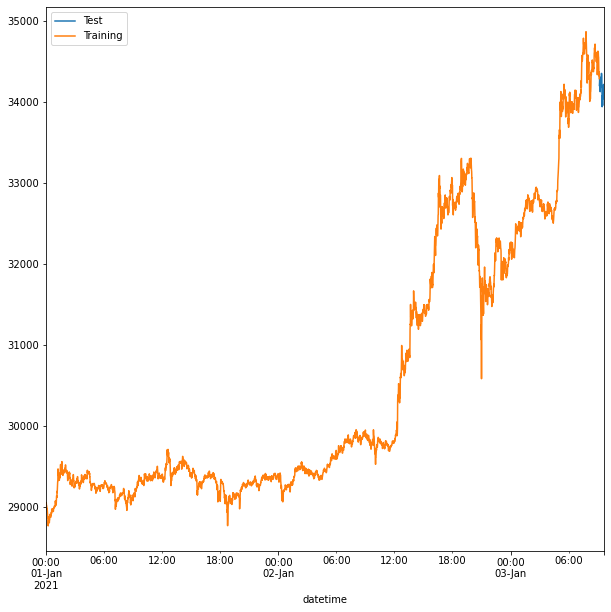

In [116]:
# plot training and test datasets
plt.figure(figsize=(10,10))
time_series_test[0].plot(label = 'Test')
time_series_training[0].plot(label = 'Training')
plt.legend()
plt.show()

## Convert to JSON and Store in S3

In [32]:
# Replace all infinite values with "NaN"
def encode_target(ts):
    return [x if np.isfinite(x) else "NaN" for x in ts]

In [33]:
encode_target(time_series_training[0][0:5])

[29000.5, 29054.5, 29027.0, 29018.5, 29010.5]

In [34]:
# Amazon DeepAR requires the training data to be in format {'start':timestamp_0, 'target': [..., ...]}
def series_to_obj(ts):
    obj = {"start": str(ts.index[0]), "target": encode_target(ts)}
    return obj

In [35]:
series_to_obj(time_series_training[0][0:5])

{'start': '2021-01-01 00:00:00',
 'target': [29000.5, 29054.5, 29027.0, 29018.5, 29010.5]}

In [36]:
def series_to_jsonline(ts):
    return json.dumps(series_to_obj(ts))

In [37]:
series_to_jsonline(time_series_training[0][0:5])

'{"start": "2021-01-01 00:00:00", "target": [29000.5, 29054.5, 29027.0, 29018.5, 29010.5]}'

Set up SageMaker configuration and define S3 bucket to store training and test data

In [38]:
session = sagemaker.Session()
bucket = session.default_bucket()
prefix = "sagemaker/DEMO-deepar-bitcoin" # change to your desired S3 prefix
region = session.boto_region_name

role = sagemaker.get_execution_role()

In [39]:
s3_output_path = "{}/output".format(prefix)
train_data_path = "s3://{}/{}/train/train.json".format(bucket, prefix)
test_data_path = "s3://{}/{}/test/test.json".format(bucket, prefix)

encoding = 'utf-8'
file_json_training = 'bitcoin_training_data.json'
file_json_test = 'bitcoin_test_data.json'

with open('train.json', 'wb') as fp:
    for ts in time_series_training:
        fp.write(series_to_jsonline(ts).encode(encoding))
        fp.write('\n'.encode(encoding))
        
# terminal command to move file to S3
! aws s3 mv train.json $train_data_path
        
with open('test.json', 'wb') as fp:
    for ts in time_series_test:
        fp.write(series_to_jsonline(ts).encode(encoding))
        fp.write('\n'.encode(encoding))
        
# terminal command to move file to S3 
! aws s3 mv test.json $test_data_path

move: ./train.json to s3://sagemaker-ap-northeast-1-715346929360/sagemaker/DEMO-deepar-bitcoin/train/train.json
move: ./test.json to s3://sagemaker-ap-northeast-1-715346929360/sagemaker/DEMO-deepar-bitcoin/test/test.json


Let's look at the role and S3 paths

In [40]:
print('Role: ', role)
print('Region: ', region)
print('Location of training data: ', train_data_path)
print('Location of training data: ', test_data_path)
print('Location of training data: ', s3_output_path)

Role:  arn:aws:iam::715346929360:role/service-role/AmazonSageMaker-ExecutionRole-20221104T110178
Region:  ap-northeast-1
Location of training data:  s3://sagemaker-ap-northeast-1-715346929360/sagemaker/DEMO-deepar-bitcoin/train/train.json
Location of training data:  s3://sagemaker-ap-northeast-1-715346929360/sagemaker/DEMO-deepar-bitcoin/test/test.json
Location of training data:  sagemaker/DEMO-deepar-bitcoin/output


## Training the DeepAR Model

In [49]:
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)
from sagemaker import image_uris

container = image_uris.retrieve(region=region, framework="forecasting-deepar")

deepar = sagemaker.estimator.Estimator(
    container,
    role,
    instance_count=1, # increase if training time is a factor | keep to 1 if cost is a factor
    instance_type="ml.m4.xlarge",
    enable_sagemaker_metrics = True,
    use_spot_instances=True,  # use spot instances (this is a cheaper alternative)
    max_run=3600,  # max training time in seconds
    max_wait=3600,  # seconds to wait for spot instance
    output_path="s3://{}/{}".format(bucket, s3_output_path),
    sagemaker_session=session,
)

freq = "min"
context_length = 5

deepar.set_hyperparameters(time_freq=freq, context_length=str(context_length), prediction_length=str(prediction_length))

hyperparameter_ranges = {
    "mini_batch_size": IntegerParameter(300, 400),
    "epochs": IntegerParameter(350, 400),
    "num_cells": IntegerParameter(40, 80),
    "likelihood": CategoricalParameter(["gaussian", "student-T"]),
    "learning_rate": ContinuousParameter(0.0001, 0.001),
}

##model object ->
##prediction -> date data -> target  -> RMSE value trained model
##train 10 days , future 15 mins , context ->RMSE value trained model

objective_metric_name = "test:RMSE"  #train:loss
#metric_definitions = [{'Name': 'test:RMSE', 'Regex': 'loss(\S+)'}]

tuner = HyperparameterTuner(
    deepar,
    objective_metric_name,
    hyperparameter_ranges,
  #  metric_definitions,
    max_jobs=2,
    strategy="Bayesian",
    objective_type="Minimize",
    max_parallel_jobs=10,
    early_stopping_type="Off",
)

s3_input_train = sagemaker.inputs.TrainingInput(
    s3_data="s3://{}/{}/train/".format(bucket, prefix), content_type="json"
)
s3_input_test = sagemaker.inputs.TrainingInput(
    s3_data="s3://{}/{}/test/".format(bucket, prefix), content_type="json"
)

tuner.fit({"train": s3_input_train, "test": s3_input_test}, include_cls_metadata=False)
tuner.wait()



No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


...................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................!
!


# Host Amazon SageMaker Model

In [51]:
from sagemaker.serializers import IdentitySerializer
from sagemaker.deserializers import JSONDeserializer

In [52]:
best_tuning_job_name = tuner.best_training_job()
best_tuning_job_name

'forecasting-deepar-221108-0952-001-32c0b2c6'

In [53]:
##create serverless endpoint since resource maxed out model / endpoint

endpoint = tuner.deploy(
    initial_instance_count=1,
    endpoint_name=best_tuning_job_name,
    instance_type="ml.t2.medium",
    serializer=IdentitySerializer(content_type="application/json"),
    deserializer=JSONDeserializer(),
    wait=True,
)

#get endpoint
# sm_boto3 = boto3.client("sagemaker")
# model_name = best_tuning_job_name  # model defined above
# initial_instance_count = 1
# instance_type = "ml.t2.medium"

# variant_name = "AMeaningfulProdVarName"  # ^[a-zA-Z0-9](-*[a-zA-Z0-9]){0,62}

# production_variants = [
#     {
#         "VariantName": variant_name,
#         "ModelName": model_name,
#         "InitialInstanceCount": initial_instance_count,
#         "InstanceType": instance_type,
#     }
# ]

# endpoint_config_name = "ExampleServeConfig"  # ^[a-zA-Z0-9](-*[a-zA-Z0-9]){0,62}

# endpoint_config = {
#     "EndpointConfigName": endpoint_config_name,
#     "ProductionVariants": production_variants,
# }

# ep_conf_res = sm_boto3.create_endpoint_config(**endpoint_config)



2022-11-08 10:38:54 Starting - Preparing the instances for training
2022-11-08 10:38:54 Downloading - Downloading input data
2022-11-08 10:38:54 Training - Training image download completed. Training in progress.
2022-11-08 10:38:54 Uploading - Uploading generated training model
2022-11-08 10:38:54 Completed - Training job completed
--------!

Deploy the best performing model for inference

# Evaluate the Model

In [141]:
class DeepARPredictor(sagemaker.predictor.Predictor):
    def __init__(self, *args, **kwargs):
        super().__init__(
            *args, serializer=IdentitySerializer(content_type="application/json"), **kwargs
        )

    def set_prediction_parameters(self, freq, prediction_length):
        """Set the time frequency and prediction length parameters. This method **must** be
        called before being able to use `predict`.

        Parameters:
        freq -- string indicating the time frequency
        prediction_length -- integer, number of predicted time points

        Return value: none.
        """
        self.freq = freq
        self.prediction_length = prediction_length

    def predict(
        self, ts, cat=None, encoding="utf-8", num_samples=100, quantiles=["0.1", "0.5", "0.9"]
    ):
        """Requests the prediction of for the time series listed in `ts`, each with the
        (optional) corresponding category listed in `cat`.

        Parameters:
        ts -- list of `pandas.Series` objects, the time series to predict
        cat -- list of integers (default: None)
        encoding -- string, encoding to use for the request (default: 'utf-8')
        num_samples -- integer, number of samples to compute at prediction time (default: 100)
        quantiles -- list of strings specifying the quantiles to compute (default: ['0.1', '0.5', '0.9'])

        Return value: list of `pandas.DataFrame` objects, each containing the predictions
        """
        prediction_times = [x.index[-1] + x.index.freq for x in ts]
        #prediction_times = [x.index[-1]  for x in ts]
        #prediction_times = ts
        req = self.__encode_request(ts, cat, encoding, num_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req)
        return self.__decode_response(res, prediction_times, encoding)

    def __encode_request(self, ts, cat, encoding, num_samples, quantiles):
        #instances = [series_to_obj(ts[k], cat[k] if cat else None) for k in range(len(ts))]
        instances = [series_to_obj(ts[k]) for k in range(len(ts))]
        configuration = {
            "num_samples": num_samples,
            "output_types": ["quantiles"],
            "quantiles": quantiles,
        }
        http_request_data = {"instances": instances, "configuration": configuration}
        return json.dumps(http_request_data).encode(encoding)

    def __decode_response(self, response, prediction_times, encoding):
        response_data = json.loads(response.decode(encoding))
        list_of_df = []
        for k in range(len(prediction_times)):
            prediction_index = pd.date_range(
                start=prediction_times[k], freq=self.freq, periods=self.prediction_length
            )
            list_of_df.append(
                pd.DataFrame(
                    data=response_data["predictions"][k]["quantiles"], index=prediction_index
                )
            )
        return list_of_df

predictor = DeepARPredictor(endpoint_name=endpoint.endpoint_name, sagemaker_session=session)

In [55]:
def add_freq(idx, freq=None):
    """Add a frequency attribute to idx, through inference or directly.

    Returns a copy.  If `freq` is None, it is inferred.
    """

    idx = idx.copy()
    if freq is None:
        if idx.freq is None:
            freq = pd.infer_freq(idx)
        else:
            return idx
    idx.freq = pd.tseries.frequencies.to_offset(freq)
    if idx.freq is None:
        raise AttributeError('no discernible frequency found to `idx`.  Specify'
                             ' a frequency string with `freq`.')
    return idx

In [136]:
ts = add_freq(time_series_test[0].index)
time_series_test[0].index = ts
len(time_series_test)

1

In [148]:
ts = add_freq(time_series_training[0].index)
time_series_training[0].index = ts
len(time_series_training)

1

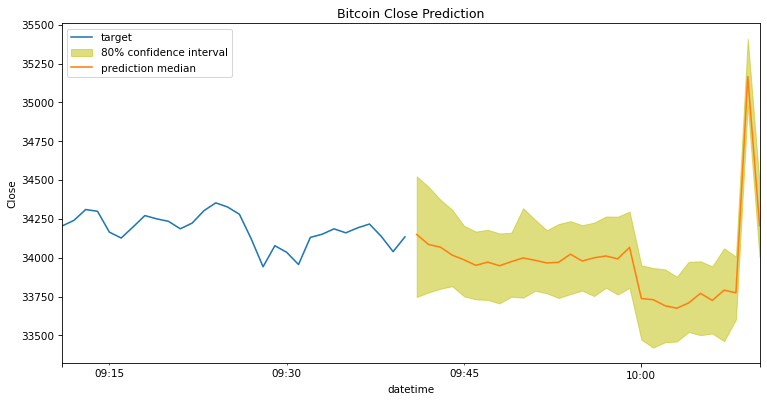

In [150]:
predictor.set_prediction_parameters(freq, prediction_length)

list_of_df = predictor.predict(time_series_test)
actual_data = time_series_test

for k in range(len(list_of_df)):
    plt.figure(figsize=(12, 6), dpi=75, facecolor="w")
    plt.ylabel("Close")
    plt.xlabel("Timestamp")
    plt.title("Bitcoin Close Prediction")
    actual_data[k][-prediction_length - context_length :].plot(label="target")
    p10 = list_of_df[k]["0.1"]
    p90 = list_of_df[k]["0.9"]
    plt.fill_between(p10.index, p10, p90, color="y", alpha=0.5, label="80% confidence interval")
    list_of_df[k]["0.5"].plot(label="prediction median")
    plt.legend()
    plt.show()

In [143]:
list_of_df

[                              0.1           0.5           0.9
 2021-01-03 09:41:00  33808.863281  34219.972656  34556.464844
 2021-01-03 09:42:00  33793.925781  34109.476562  34352.792969
 2021-01-03 09:43:00  33783.757812  34086.171875  34390.089844
 2021-01-03 09:44:00  33673.281250  34038.945312  34357.562500
 2021-01-03 09:45:00  33695.898438  33965.207031  34149.019531
 2021-01-03 09:46:00  33717.820312  33953.019531  34223.105469
 2021-01-03 09:47:00  33751.566406  33952.898438  34135.445312
 2021-01-03 09:48:00  33745.042969  33968.621094  34181.289062
 2021-01-03 09:49:00  33720.660156  33962.156250  34208.500000
 2021-01-03 09:50:00  33711.546875  33971.257812  34217.765625
 2021-01-03 09:51:00  33720.441406  33971.027344  34228.707031
 2021-01-03 09:52:00  33679.921875  33956.417969  34213.195312
 2021-01-03 09:53:00  33757.468750  33997.472656  34242.351562
 2021-01-03 09:54:00  33704.757812  33985.625000  34235.226562
 2021-01-03 09:55:00  33876.976562  34013.730469  34228

# Clean Up

To avoid additional costs we want to remove the model and endpoints instances. Furthermore, remember to close and halt this Jupyter Notebook:
- Navigate to file -> 'close and halt'
- Navigate to SageMaker -> notebook instances -> click on notebook -> actions -> stop

In [ ]:
predictor.delete_model()
predictor.delete_endpoint()